In [ ]:
# import
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import scipy
from matplotlib.pyplot import *
from scipy import ndimage as ndi
from scipy.signal import convolve2d as conv2
from skimage.morphology import disk
from skimage.filters import median
from skimage.morphology import skeletonize
from skimage import color, data, restoration, feature, filters, measure, morphology, segmentation, util

In [ ]:
def print_image( image_in , in_title= None, image_out= None, out_title= None):
    if image_out is None:
        fig, ax = subplots( 1, figsize = (10, 10))
        ax.imshow(image_in, cmap='gray')
        ax.set_title(in_title, fontsize = 20)
    else:
        fig, ax = subplots( 1, 2, figsize = (20, 10))
        ax[0].imshow(image_in, cmap='gray')
        ax[0].set_title(in_title, fontsize = 20)
        ax[1].imshow(image_out, cmap='gray')
        ax[1].set_title(out_title, fontsize = 20)

In [ ]:
# Read image
path = '0_10.ome.tiff'
org_img = tifffile.imread(path).astype('int')
image_0 = org_img[1, 50]

In [ ]:
# Normalization
def Normalization(image_0,want_print=True):
    image_in = image_0.copy()
    contrast = 200
    brightness = 20
    bit = 10
    max_brightness = 2**bit - 1
    image_out = image_in * (contrast / max_brightness + 1) - contrast + brightness
    image_out = np.clip(image_out, 0, max_brightness)
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Normalization'
        print_image( image_in, in_title, image_out, out_title )
    
    image_1 = image_out.copy()
    return image_1

In [ ]:
# Median
def Median(image_1,want_print=True):
    image_in = image_1.copy()
    disk_size = 2
    image_out = median( image_in, disk(disk_size) )

    if (want_print):
        in_title = 'Original image'
        out_title = 'Median'
        print_image( image_in, in_title, image_out, out_title )
    
    image_2 = image_out.copy()
    return image_2

In [ ]:
# Closing
def Closing(image_2,want_print=True):
    image_in = image_2.copy()
    kernel_size = 2
    close_kernel = np.ones((kernel_size, kernel_size), np.uint8)
    image_out = cv2.morphologyEx(image_in, cv2.MORPH_CLOSE, close_kernel)
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Closing'
        print_image( image_in, in_title, image_out, out_title )
    
    image_3 = image_out.copy()
    return image_3

In [ ]:
# Multi-Otsu thresholding
def MultiOtsu(image_in,want_print=True):

    num_classes = 3
    Otsu_thresholds = filters.threshold_multiotsu(image_in, classes = num_classes)
    threshold = Otsu_thresholds[1]
    
    image_out = np.ones(image_in.shape)
    image_out[image_in < threshold] = 0
    

    if (want_print):
        in_title = 'Original image'
        out_title = 'Multi-Otsu thresholding'
        print_image( image_in, in_title, image_out, out_title )

    return image_out

In [ ]:
# Fill holes
def fill_holes(image_in,want_print=True):
    image_out = scipy.ndimage.morphology.binary_fill_holes(image_in)
    if (want_print):
        in_title = 'Original image'
        out_title = 'Fill holes'
        print_image( image_in, in_title, image_out, out_title )
    return image_out

In [ ]:
# Dendrite and Bouton
def seperate_d_b(image_input,want_print=True):
    image_in = image_input.astype('bool')
    threshold = 300
    dendrite_0 = morphology.remove_small_objects(image_in, threshold)
    bouton_0 = image_in.copy()
    bouton_0[ dendrite_0 == 1 ] = 0
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Dendrite'
        print_image( image_in, in_title, dendrite_0, out_title )
        in_title = 'Original image'
        out_title = 'Bouton'
        print_image( image_in, in_title, bouton_0, out_title )
    
    return dendrite_0,bouton_0

In [ ]:
# Adptive mean
def adaptive_mean(image_in,want_print=True):
    disk_size = 4
    smoother_higher = filters.rank.mean(util.img_as_ubyte(image_in), morphology.disk(disk_size))
    image_out = smoother_higher > 140 # hyperparameter???
    if (want_print):
        in_title = 'Original image'
        out_title = 'Adptive mean'
        print_image( image_in, in_title, image_out, out_title )
    bouton_1 = image_out.copy()

    return bouton_1

In [ ]:
# Skeletonization
def Skeletonization(image_in,want_print=True):
    image_out = skeletonize(image_in)
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Skeletonization'
        print_image( image_in, in_title, image_out, out_title )
    
    dendrite_1 = image_out.copy()
    
    return dendrite_1

In [ ]:
# Body and Spine
from fil_finder import FilFinder2D
import astropy.units as u

def seperate_b_s(image_in,want_print=True):
    skeleton = image_in.copy()
    fil = FilFinder2D(skeleton, distance=250 * u.pc, mask=skeleton)
    fil.preprocess_image(flatten_percent=85)
    fil.create_mask(border_masking=True, verbose=False, use_existing_mask=True)
    fil.medskel(verbose=False)
    fil.analyze_skeletons(skel_thresh=10 * u.pix,prune_criteria='length')
    
    body_0 = np.zeros(image_in.shape)
    print(fil.branch_properties['pixels'])

    for idx, filament in enumerate(fil.filaments):
        x, y = filament.longpath_pixel_coords
        for i in range( len(x) ):
            body_0[x[i], y[i]] = 1

    spine_0 = image_in.copy()
    spine_0[ body_0 == 1 ] = 0
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Body'
        print_image( image_in, in_title, body_0, out_title )
        in_title = 'Original image'
        out_title = 'Spine'
        print_image( image_in, in_title, spine_0, out_title )
    
    return body_0,spine_0

In [ ]:
# False spine
"""
def false_spine(spine_0,want_print=True):
    image_in = spine_0.copy()
    threshold = 3
    image_out = morphology.remove_small_objects(image_in, threshold)

    if (want_print):
        in_title = 'Original image'
        out_title = 'Real spine'
        print_image( image_in, in_title, image_out, out_title )
    
    spine_1 = image_out.copy()
    return spine_1
"""
# 好像有問題

In [ ]:
# Thin or Mushroom
def get_no_stubby(image_in,want_print=True):
    image_out = np.zeros(image_1.shape)
    
    threshold = 5
    stubby = morphology.remove_small_objects(image_in, threshold)
    image_out[ stubby != image_in ] = 1
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Thin or Mushroom'
        print_image( image_in, in_title, image_out, out_title )
    
    return image_out

In [ ]:
# Stubby
def get_stubby(image_in,want_print=True):
    
    threshold = 5
    image_out = morphology.remove_small_objects(image_in, threshold)

    if (want_print):
        in_title = 'Original image'
        out_title = 'Stubby'
        print_image( image_in, in_title, image_out, out_title )
    
    return image_out

In [ ]:
# Body and Spine
from fil_finder import FilFinder2D
import astropy.units as u

def seperate_b_s(image_in,want_print=True):
    skeleton = image_in.copy()
    fil = FilFinder2D(skeleton, distance=250 * u.pc, mask=skeleton)
    fil.preprocess_image(flatten_percent=85)
    fil.create_mask(border_masking=True, verbose=False, use_existing_mask=True)
    fil.medskel(verbose=False)
    fil.analyze_skeletons(skel_thresh=10 * u.pix,prune_criteria='length')
    
    body_0 = np.zeros(image_in.shape)
    
    for idx, filament in enumerate(fil.filaments):
        x, y = filament.longpath_pixel_coords
        for i in range( len(x) ):
            body_0[x[i], y[i]] = 1

    spine_0 = image_in.copy()
    spine_0[ body_0 == 1 ] = 0
    
    if (want_print):
        in_title = 'Original image'
        out_title = 'Body'
        print_image( image_in, in_title, body_0, out_title )
        in_title = 'Original image'
        out_title = 'Spine'
        print_image( image_in, in_title, spine_0, out_title )
    
    return body_0,spine_0

In [ ]:
#separate real dendrite and axon
def find_real_dendrite(image_in,image_in_2,want_print=True):
    spine_0 = image_in.copy()
    dendrite_0 = image_in_2.copy()
    label_img = measure.label(image_in_2)
    den_area = measure.regionprops(label_img)
    dendrite_id = np.zeros(len(den_area)+1)
    
    for i in range(1,999):
        num = len(np.where(measure.label(image_in)==i)[0])
        if(num==0):
            break
        
        x = np.where(measure.label(image_in)==i)[0][0]
        y = np.where(measure.label(image_in)==i)[1][0]
        dendrite_id[measure.label(image_in_2)[x,y]]+=1
    for i in range(len(den_area)+1):
        print(i,dendrite_id[i])
        if (dendrite_id[i]<7): # density: (dendrite_id[i]-2)/den_area[i]['Area']<(1/200)
            image_in_2[np.where(label_img==i)]=0
        #print(props[i]['Area']) # area
        
    if (want_print):
        fig, ax = plt.subplots(ncols=2, figsize=(32, 16))
        color_image_2 = measure.label(dendrite_0)
        ax[0].imshow(color.label2rgb(measure.label(dendrite_0), bg_label=0))
        ax[0].set_title('Segmented nuclei')
        ax[0].axis('off')
        ax[1].imshow(color.label2rgb(image_in_2, bg_label=0))
        ax[1].set_title('Segmented nuclei')
        ax[1].axis('off')
        plt.show()
        
    
    del_axon = image_in_2.copy()
    return del_axon

In [ ]:
# Skeleton on origianl image
def skeleton_on_image(image_1, dendrite_1, want_print=True):
    image_in = image_1.copy()
    skeleton = dendrite_1.copy()

    image_out = np.zeros((image_in.shape[0], image_in.shape[1], 3), dtype = np.uint8 )

    for r in range( image_in.shape[0] ):
        for c in range( image_in.shape[1] ):
            tmp = image_in[ r ][ c ] * 255 // 1023 
            image_out[ r ][ c ]  = [ tmp, tmp, tmp ]
    image_out[ skeleton != 0 ] = [ 255, 0, 0 ]

    if want_print:
        fig, ax = subplots( 1, 2, figsize = (20, 10))
        in_title = 'Original'
        ax[0].imshow(image_in, cmap='gray')
        ax[0].set_title(in_title, fontsize = 20)
        out_title = 'Skeleton on origianl image'
        ax[1].imshow(image_out)
        ax[1].set_title(out_title, fontsize = 20)

In [ ]:
# Disk size per point
def point_size( image_in, kr, kc ):
    prop = 0.85
    threshold = 5
    for size in range( 1, min( image_in.shape[0], image_in.shape[1] ) ):
        overlap_disk = disk( size )
        count = np.count_nonzero(overlap_disk == 1 ) * 0.85
        num = 0
        for r in range( overlap_disk.shape[0] ):
            for c in range( overlap_disk.shape[1] ):
                if overlap_disk[ r ][ c ] == 1:
                    if kr + r - size >= 0 and kc + c - size >= 0 \
                        and kr + r - size < image_in.shape[0] \
                            and kc + c - size < image_in.shape[1]:
                            if image_in[ kr + r - size ][ kc + c - size ] == 1:
                                num += 1
        if num < count:
            return size - 1

In [ ]:
"""
# Disk size
def overlaping( image_in, want_print=True ):
    image_out = numpy.zeros(image_in.shape)

    for r in range( image_in.shape[0] ):
        for c in range( image_in.shape[1] ):
            image_out[ r ][ c ] = point_size( image_in, r, c )
    return image_out
"""

In [54]:
# Mark
from fil_finder import FilFinder2D
import astropy.units as u

def mark(image_in,binary,want_print=True):
    skeleton = image_in.copy()
    fil = FilFinder2D(skeleton, distance=250 * u.pc, mask=skeleton)
    fil.preprocess_image(flatten_percent=85)
    fil.create_mask(border_masking=True, verbose=False, use_existing_mask=True)
    fil.medskel(verbose=False)
    print(1*u.pix)
    fil.analyze_skeletons(skel_thresh = 0.1 * u.pix, prune_criteria='all')
    

    image_out_skeleton = np.zeros((image_in.shape[0], image_in.shape[1], 3), dtype = np.uint8 )
    image_out_binary = np.zeros((image_in.shape[0], image_in.shape[1], 3), dtype = np.uint8 )

    for r in range( image_in.shape[0] ):
        for c in range( image_in.shape[1] ):
            if image_in[ r ][ c ]:
                image_out_skeleton[ r ][ c ] = [ 255, 255, 255 ]
            if binary[ r ][ c ]:   
                image_out_binary[ r ][ c ] = [ 255, 255, 255 ]

    for idx, filament in enumerate(fil.filaments): 
        data = filament.branch_properties.copy()
        pixels = data['pixels']
        offset_pixels = map(lambda x: x+filament.pixel_extents[0], pixels)
        for item in offset_pixels:
            length = len(item) - 1
            x, y = item[ (int)(length * 0.2) ]
            image_out_skeleton[ x ][ y ] = [ 255, 0, 0 ]
            image_out_binary[ x ][ y ] = [ 255, 0, 0 ]
            print(item[(int)(length * 0.2)])
            print(point_size(binary, x, y))
            x, y = item[ (int)(length * 0.8) ]
            image_out_skeleton[ x ][ y ] = [ 255, 0, 0 ]
            image_out_binary[ x ][ y ] = [ 255, 0, 0 ]
            print(item[(int)(length * 0.8)])
            print(point_size(binary, x, y))
    
    if (want_print):    
        fig, ax = subplots( 1, 2, figsize = (20, 10))
        in_title = 'Original'
        ax[0].imshow(image_in, cmap='gray')
        ax[0].set_title(in_title, fontsize = 20)
        out_title = 'Mark'
        ax[1].imshow(image_out_skeleton)
        ax[1].set_title(out_title, fontsize = 20)
        
        fig, ax = subplots( 1, 2, figsize = (20, 10))
        in_title = 'Original'
        ax[0].imshow(binary, cmap='gray')
        ax[0].set_title(in_title, fontsize = 20)
        out_title = 'Mark'
        ax[1].imshow(image_out_binary)
        ax[1].set_title(out_title, fontsize = 20)

    return image_out_skeleton

C:\Users\CHENGCHUNGYU\AppData\Local\Programs\Python\Python38\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\CHENGCHUNGYU\AppData\Local\Programs\Python\Python38\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\CHENGCHUNGYU\AppData\Local\Programs\Python\Python38\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\CHENGCHUNGYU\AppData\Local\Programs\Python\Python38\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\CHENGCHUNGYU\AppData\Local\Programs\Python\Python38\lib\si

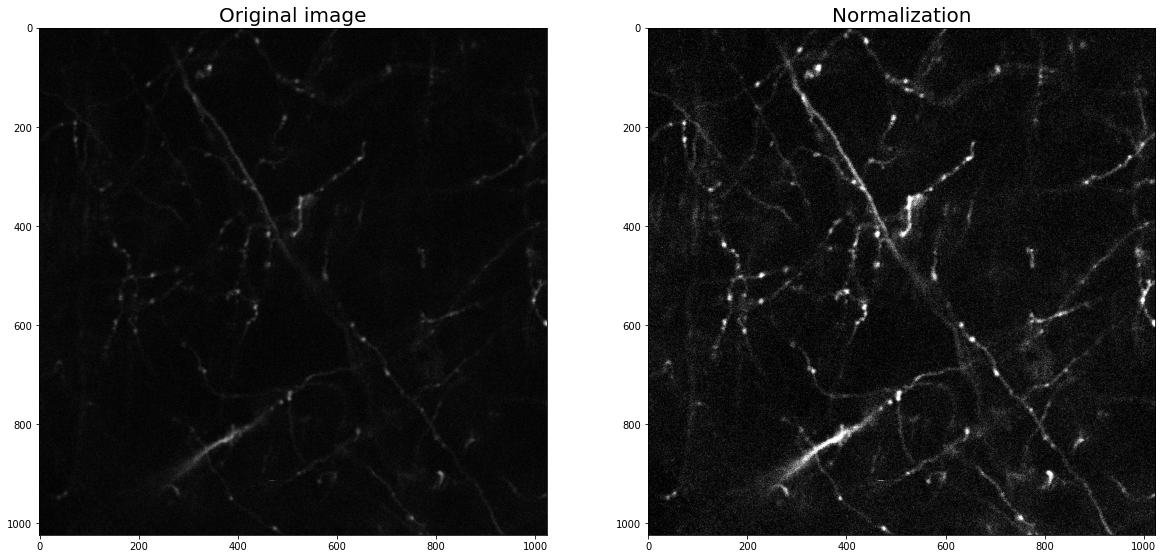

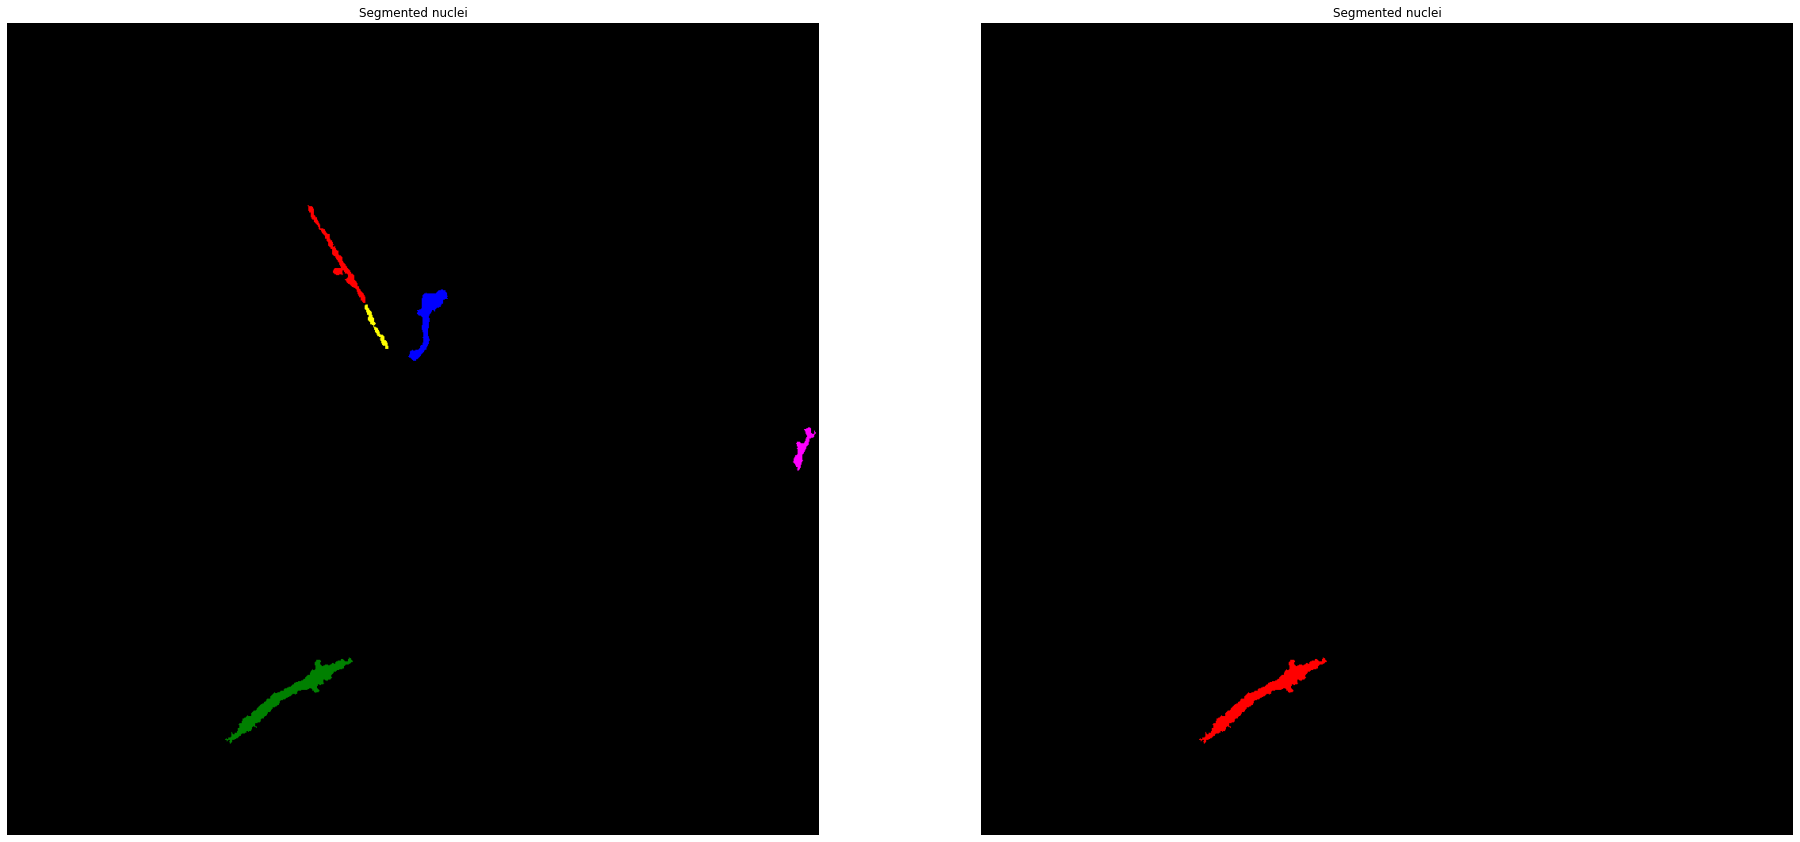

0.0
new
1.0 pix
[309 424]
0
[311 422]
0
[313 418]
0
[313 418]
0
[314 420]
0
[316 422]
0
[324 428]
0
[325 431]
0
[341 550]
0
[341 550]
0
[342 549]
0
[342 549]
0
[355 534]
0
[361 539]
0
[364 520]
0
[365 526]
0
[ 514 1012]
0
[ 514 1012]
0
[ 515 1011]
0
[ 515 1011]
0
[ 516 1019]
0
[ 521 1013]
0
[530 998]
0
[ 533 1000]
0
[807 393]
3
[816 394]
11
[827 392]
12
[832 397]
2
[835 387]
7
[842 390]
2
[883 309]
6
[886 312]
0
[896 284]
0
[899 285]
4
[905 283]
0
[907 282]
0


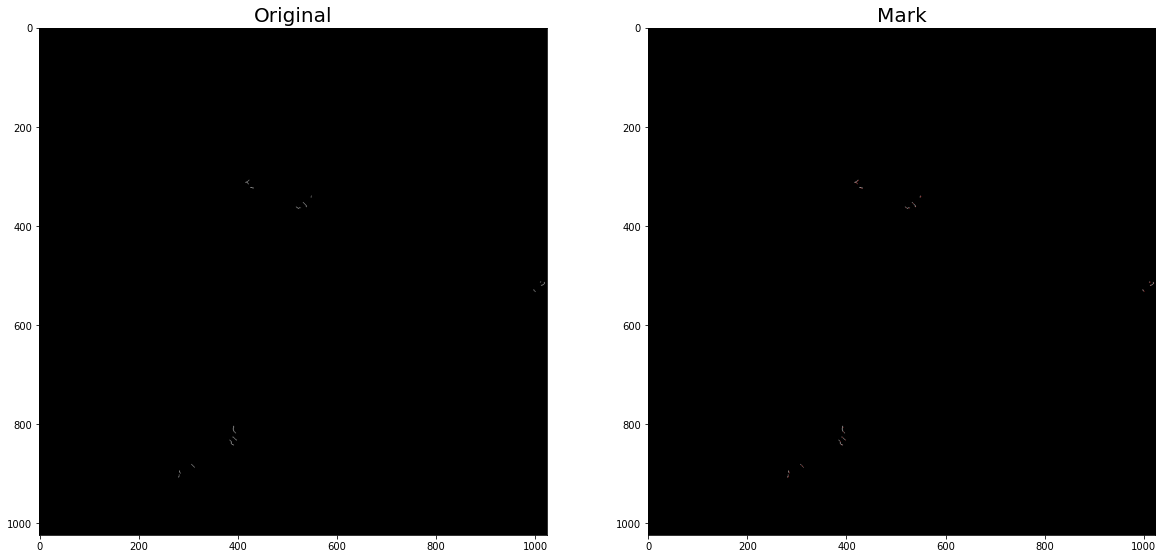

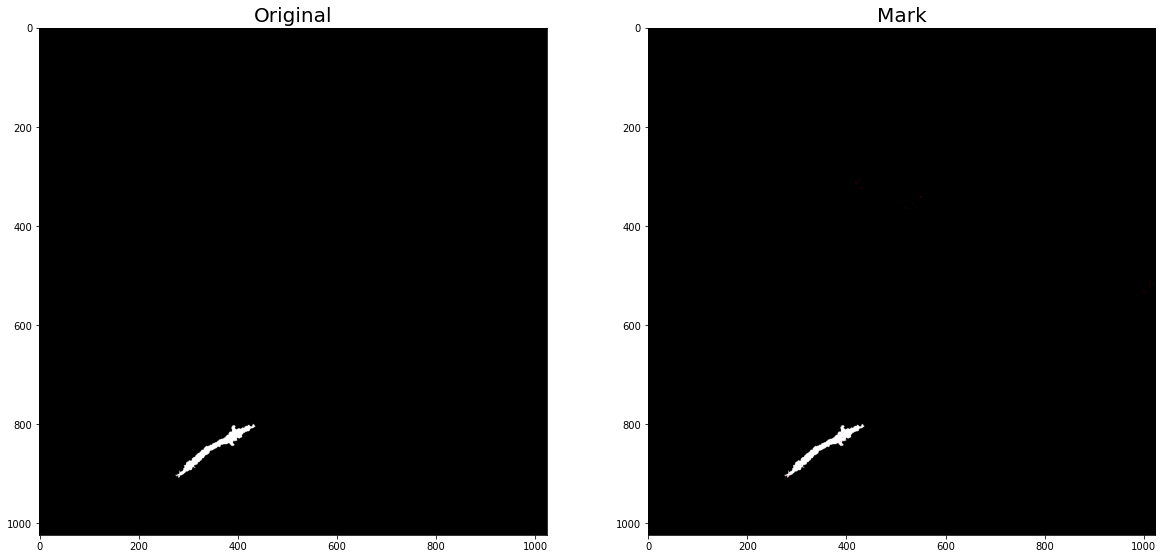

In [55]:
dendrite_id = np.zeros((org_img.shape[1:]))
dend_count = 1
for i in range(27,28): # 28
    image_0 = org_img[1,i]
    image_1 = Normalization(image_0)
    image_2 = Median(image_1,False)
    image_3 = Closing(image_2,False)
    image_4 = MultiOtsu(image_3,False)
    image_5 = fill_holes(image_4,False)
    dendrite_0,bouton_0 = seperate_d_b(image_5,False)
    bouton_1 = adaptive_mean(bouton_0,False)
    dendrite_1 = Skeletonization(dendrite_0,False)
    body_0,spine_0 = seperate_b_s(dendrite_1,False)
    del_axon = find_real_dendrite(spine_0,dendrite_0)
    if (i==0):
        dendrite_id[i],count = measure.label(del_axon,return_num=True)
        dend_count = dend_count+count
    else:
        dendrite_id[i],count = measure.label(del_axon,return_num=True)
        org_dend = (dendrite_id[i-1]!=0) #
        for j in range(1,count+1):
            overall = (org_dend[np.where(dendrite_id[i]==j)]==True).shape[0]
            org_id = org_dend[np.where(dendrite_id[i]==j)]==True
            #print((org_dend[np.where(dendrite_id[i]==j)]==True)[0:120])
            overlap = np.count_nonzero((org_dend[np.where(dendrite_id[i]==j)]==True))
            print(overlap/overall)
            if(overlap/overall>0.45): #重疊率高達8成就要留下
                print('same')
                want_id = np.sort(dendrite_id[i-1][np.where(dendrite_id[i]==j)])[-1] 
                dendrite_id[i][np.where(dendrite_id[i]==j)]=want_id
            #if(overlap/overall<0.65 and overlap/overall>0.45):
            #    print('wrong')
            #    unwant_id = np.sort(dendrite_id[i-1][np.where(dendrite_id[i]==j)])[-1] 
            #    dendrite_id[i-1][np.where(dendrite_id[i-1]==unwant_id)]=0
            #    dendrite_id[i][np.where(dendrite_id[i]==j)]=0
            #    dend_count = dend_count - 1
            if(overlap/overall<0.15): #重疊率太低代表新的
                print('new')
                dendrite_id[i][np.where(dendrite_id[i]==j)]=dend_count #新的神經id
                dend_count = dend_count+1
    skeleton_on_image(image_1, dendrite_1,False)
    stubby = get_stubby(spine_0,False)
    thin_or_mushroom = get_no_stubby(spine_0,False)
    marked_thin_or_mushroom = mark(spine_0, dendrite_0, True)

In [ ]:
print_image(color.label2rgb(dendrite_id[23], bg_label=0))

In [ ]:
[np.where(dendrite_id[i]==0)]

In [ ]:
i=24
org_dend = (dendrite_id[i-1]!=0)
for j in range(1,count+1):
    overall = (org_dend[np.where(dendrite_id[i]==j)]==True).shape[0]
    #print((org_dend[np.where(dendrite_id[i]==j)]==True)[0:120])
    overlap = np.count_nonzero((org_dend[np.where(dendrite_id[i]==j)]==True))
    print(overlap/overall)

In [ ]:
# Bounding box
# haven't solved
"""
image_in = spine.copy()

image_BGR = cv2.cvtColor(np.int8(image_in), cv2.COLOR_GRAY2BGR)
image_GRAY = cv2.cvtColor(image_BGR, cv2.COLOR_BGR2GRAY)
th, binary = cv2.threshold(image_GRAY, 0, 255, cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image_BGR, contours, -1, (0, 0, 255), 3)
 
bounding_boxes = [cv2.boundingRect(cnt) for cnt in contours]
 
for bbox in bounding_boxes:
     [x , y, w, h] = bbox
     cv2.rectangle(image_BGR, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow("name", bgr_img)
cv2.waitKey(0)

fig, ax = subplots( 1, 2, figsize = (20, 10))
in_title = 'Original'
ax[0].imshow(image_in, cmap='gray')
ax[0].set_title(in_title, fontsize = 20)
out_title = 'Bounding box'
ax[1].imshow(image_out)
ax[1].set_title(out_title, fontsize = 20)
"""